In [1]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits import mplot3d
%matplotlib inline

The following are parameters that this simulation runs on, You can freely modify these. (Don't increase T/dt too much or the simulation takes forever)


In [2]:

#np . random . seed (1245467)

N = 20 # number of particles
L = 10.0 # box side length
dt = 0.001 # time step
T = 10# number of steps to simulate
F=None
e=1 #Elasticity of all collisions
pos=np.random.rand(N,3)*L
vel=np.random.rand(N,3)*(L/2)-(L/4)
mass=np.ones(N)
#IMPLEMENTS acceleration due to gravity, modify g to your preferred value.
g=np.array([0,0,0])
#toggles paired_forces 
pf=False
#choose how to handle out of bounds
Out_of_bounds="recycle"
#feel free to modify these


These define a surface in a 3-dimensional space, a function to differentiate said function w.r.t to z, and a normal function to give the unit normal vector at any point on the surface, these are used later in fcollide()

In [3]:
# f(x,y) defines any mathematical surface, feel free to change it
def S_f(x,y):
    return 5-np.sqrt(50-(x-5)**2-(y-5)**2)
    #return np.ones(x.shape)*5
def S_g(x,y):
    return 5+np.sqrt(50-(x-5)**2-(y-5)**2)
surfaces=[]#[[S_f,False],[S_g,True]]
def d(f,x,y,h=1e-5):
    return (f(x+h,y)-f(x-h,y))/(2*h),(f(x,y+h)-f(x,y-h))/(2*h)

def normal(f,x,y):
    #numerically differentiates the function at x,y (For perfomance reasons, it would be better if you analytically differentiate whenever possible)
    dfx,dfy=d(f,x,y)
    #recall the equation of normal vector to a surface
    n=np.array([-dfx,-dfy,np.ones_like(dfx)]).T
    return n/np.linalg.norm(n,axis=1,keepdims=True) #normalising to get a unit vector

This is just there to ensure that all points are initially above the surface. 

In [4]:
def fcorrect(f,pos,topsurface=False):
     mask=(pos[:,2]-f(pos[:,0],pos[:,1]))<0 if not topsurface else (pos[:,2]-f(pos[:,0],pos[:,1]))>0
     v=vel[mask]
     n=normal(f,pos[mask,0],pos[mask,1])
     epsilon=0
     pos[mask,2]=f(pos[mask,0],pos[mask,1])
     pos[mask]+=n*epsilon
for surface in surfaces:
     fcorrect(surface[0],pos,topsurface=surface[1])
pos

array([[6.53978427, 7.19302456, 6.25097049],
       [0.90793772, 0.9367591 , 1.6109143 ],
       [7.31967409, 0.29567579, 6.32354105],
       [3.36038781, 6.76097531, 6.35586662],
       [1.72515202, 1.3879574 , 4.71396186],
       [4.17297752, 6.62209108, 2.04790698],
       [6.24912664, 4.50141523, 0.02595983],
       [3.20041461, 7.26328933, 8.28224933],
       [9.64700141, 9.36189245, 0.48458695],
       [2.28837491, 9.95164019, 3.63917153],
       [7.49504826, 6.36581886, 0.09483327],
       [5.69468106, 3.36676144, 3.95124289],
       [3.30753873, 3.52858611, 4.85510319],
       [1.20525135, 2.84658193, 1.01442397],
       [0.77517589, 9.75155025, 7.22357231],
       [7.18182901, 8.29805283, 0.45814345],
       [0.05339166, 8.98276049, 1.40290197],
       [3.17434347, 0.99537904, 7.52479233],
       [2.50791129, 4.97898941, 9.16394393],
       [5.72985917, 3.91232125, 1.26214646]])

The same walls reflect code, expanded to work for 3 dimensions

In [5]:

def walls_reflect ( pos , vel , L ):
    for i in range(3):
        left_hits = pos [: , i] < 0
        vel [ left_hits , i] *= -e # flip x velocity
        pos [ left_hits , i] = abs(pos [ left_hits , i] )# push back inside

        right_hits = pos [: , i] > L
        vel [ right_hits , i] *= -e
        pos [ right_hits , i] =np.array([2*L])-pos[right_hits, i]
    return pos , vel

def modreturn(pos,vel,L):
    pos[:]=pos%L

def random_recycle(pos,vel,L):
    mask= (pos<0).any(axis=1) | (pos>L).any(axis=1)
    for pos_ in pos[mask]:
        pos_=np.random.rand(3)
        pos_[np.random.choice([0,1,2])]=np.random.choice([0,L])
    
random_recycle(pos,vel,L)
handle_OB={"reflect":walls_reflect,"return":modreturn, "recycle":random_recycle}

The pair_forces functions in the template code which I've left unchanged.(This function is already pretty efficient and I didn't see anything obvious to improve upon)

In [6]:
k = 15.0
r0 = 0.8
rc = 2.0
def pair_forces (pos):
    F = np.zeros_like (pos)
    d = pos[ None ,: ,:]-pos [: , None ,:] # pairwise displacements (N,N ,3)
    #print(d)
    r = np . linalg . norm (d , axis =2) # pairwise distances (N,N)
    mask = ( r < rc ) & ( r > 1e-12) # ignore self and far pairs
    u = d /(r[: ,: , None ] + 1e-12) # unit vectors
    fmag = -k * (r - r0) * mask
    F = np.sum (fmag [: ,: , None ]*u,axis =1)
    return F

We have additionally implemented collisions between particles and collisions between particles and another surface(refer to previous cells). The function is completely vectorized but still O($n^2$) 
These, along with the O($n^2$) paired_forces are the main bottleneck for the simulation to run (not including visualisation).

In [7]:
def collision(pos,vel,mass):
     d = pos[ None ,: ,:]-pos [: , None ,:] # pairwise displacements (N,N ,3)
     r = np . linalg . norm (d , axis =2) # pairwise distances (N,N)
     velrel=vel[None:,:]-vel[:,None,:]
     velproj=((d*velrel).sum(axis=2)/(r**2+1e-12))[:,:,None]*d
     m1=mass[:,None,None]
     m2=mass[None,:,None]
     mask=((d*velrel).sum(axis=2)<0)  & ( r < 1e-1)  & ( r>1e-12)
     delv =(1 + e) * (m2 / (m1 + m2)) * velproj
     delv[~mask] = 0 
      
     vel[:,:]+=np.sum(delv,axis=1)
def fcollide(f,pos,vel,topsurface=False):
     mask=(pos[:,2]-f(pos[:,0],pos[:,1]))>=0 if topsurface else (pos[:,2]-f(pos[:,0],pos[:,1]))<=0
     v=vel[mask]
     n=normal(f,pos[mask,0],pos[mask,1])
     #shift it a little along the normal, (experimental)
     epsilon=1e-1
     pos[mask,2]=f(pos[mask,0],pos[mask,1])
     pos[mask]+=n*epsilon
     vel[mask,:]-=(1+e)*((v*n).sum(axis=1,keepdims=True))*n


#Testing
#pair_forces(pos)
#print(vel)
#collision(pos,vel,mass)
#print(vel)

Defines kinetic_energy which will be displayed on the title of the simulation, every 240 frames

In [8]:
def kinetic_energy(vel,mass):
       KE= 0.5*mass*(vel**2).sum(axis=1)
       return KE.sum()

The main function that updates the positions, velocity  and forces.

In [9]:
def step_smooth ( pos , vel , mass , dt , L , F_prev = None ):
 # 1. Force at old positions
    if F_prev is None :
        F_prev = pair_forces ( pos )
    if not pf:
       F_prev=0
    a_prev = F_prev / mass [: , None ]+g[None,:]

 # 2. Half velocity update
    vel_half = vel + 0.5 * a_prev * dt

    # 3. Move positions
    pos_new = pos + vel_half * dt
    handle_OB[Out_of_bounds] ( pos_new , vel_half , L )
    
    # 4. New forces
    F_new=0
    if pf:
       F_new = pair_forces ( pos_new )
    
    a_new = F_new / mass [: , None ]+g
    vel_new = vel_half + 0.5 * a_new * dt
    collision(pos_new, vel_new,mass)
    for surface in surfaces:
     fcollide(surface[0],pos_new,vel_new,topsurface=surface[1])
    
    return pos_new , vel_new , F_new


We are using this function to generate the data that will be used in the visualisation of this simulation. Since 3d-rendering is computationaly expensive(especially since matplotlib doesn't support multitasking or gpu-acceleration), I have decided to run the much less expensive process seperately.

In [10]:
t0=time.time()

states=np.zeros((int(T/dt)+1,3,N,3))
states[0,0]=pos
states[0,2]=np.zeros((N,3))
states[0,1]=vel
def generatedata():
    for i in range(0,int(T/dt)):
        p,v,f=step_smooth(states[i,0],states[i,1],mass,dt,L,states[i,2])
        states[i+1,0]=p
        states[i+1,1]=v
        states[i+1,2]=f
        
        
generatedata()
print(time.time()-t0)

18.549346208572388


This finds the kinetic energy for the purpose of plotting. As you can see the kinetic energy increases rapidly in the first few hundred frames due to the paired forces increasing their velocites, but afterwards remains mostly constant with small fluctuations, because the energy is now more evenly distributed between kinetic and Potential energies, as expected of a bound system. (You can modify the elasticity, introduce gravity or ignore the paired_forces altogether and see how this changes).

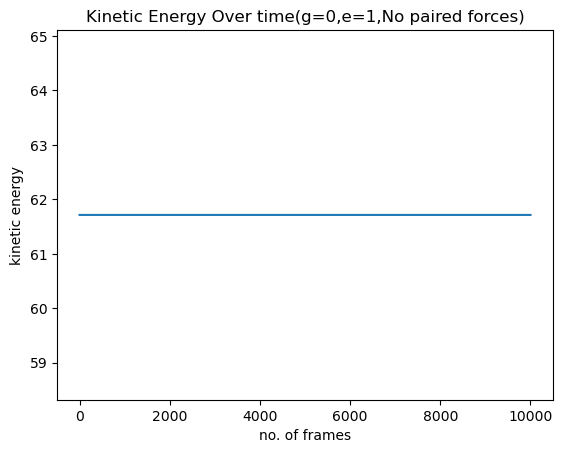

In [11]:
def bKE(bvel,mass):
       KE= 0.5*(mass[None,:,None]*(bvel**2)).sum(axis=2)
       return KE.sum(axis=1)
KEs=bKE(states[:,1],mass)
plt.close()
plt.title(f"Kinetic Energy Over time(g={g[2]},e={e},{"" if pf else "No"} paired forces)")
plt.ylabel("kinetic energy")
plt.xlabel("no. of frames")
plt.plot(np.arange(1,int(T/dt)+1),KEs[1:])

plt.show()

This block of code allows us to visualize the data produced by this simulation in the form of a matplotlib animation. We're using the HTML writer to take the plots of individual frames and render them into an animation. This process is very expensive, especially because it runs on only one thread. To ensure these animations don't take forever to render, We are only rendering 1 in every fsr(=100) state produced by the generate_data() function. This is another reason We've seperated this from the generate_data functon. The animation produced has an FPS of fps(=24) and I've set the maximum memory it can take upto embed_MB (=100, which can be modified).

In [12]:
embed_MB=100
matplotlib.rcParams['animation.embed_limit']=embed_MB
t0=time.time()
fig = plt.figure(figsize = (5,5))
ax = plt.axes(projection="3d")              
ax.set_xlim(0,L)
ax.set_ylim(0,L)
ax.set_zlim(0,L)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
title=ax.set_title(f"Kinetic energy:{kinetic_energy(states[0,1],mass)}")
r=np.linspace(0,10,10)
X,Y=np.meshgrid(r,r)
for surface in surfaces:
    ax.plot_surface(X,Y, surface[0](X,Y), alpha=0.4)
points, = ax.plot(pos[:,0], pos[:,1], pos[:,2],'ro', markersize=8,alpha=1)


def init():
    points.set_data([], [])
    points.set_3d_properties([])
    return (points,)

def update(frames):
    
    points.set_data(states[frames,0,:,0], states[frames,0,:,1])
    points.set_3d_properties(states[frames,0,:,2])
    if(frames%240==1):
        title.set_text(f"Kinetic energy:{kinetic_energy(states[frames,1],mass)}")
        #print(pos)
    return (points,)
    
def mainsimulanimate(pos, vel, L,mass,dt,fps,Fsr):
    ani = animation.FuncAnimation(fig, update,frames=range(1,int(T/dt),Fsr),init_func=init, blit=True, interval=1000/fps) 
    return HTML(ani.to_jshtml())
    #ani.save("particles.html",)
        
fps=24 #frames per second of the simulation
Fsr=100#1 out of Fsr frames are sampled(allows me to get away with low fps without affecting simulation precision)
X=mainsimulanimate(pos, vel, L,mass,dt,fps,Fsr)
print(time.time()-t0)

X

24.102643251419067


This concludes our project. It has been a really fun experience for us, and we learnt a lot making this. I also hope this project meets your expectations.

Thanking you,

Aneesh Shastri, Alisha Lavania, Nandini Agarwal, Sai Nishanth.

Roll No:

Aneesh Shastri-co25btech11004 ,
Nandini Agarwal-co25btech11017 ,
Alisha Lavania-co25btech11003 ,
Sai Nishanth-ms25btech11008 .